<a href="https://colab.research.google.com/github/Tudou77/DS340W/blob/main/Final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## load data

In [5]:
#Import tools we need
import requests
from io import StringIO
import numpy as np 
import pandas as pd 
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error,precision_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb 

url="https://drive.google.com/file/d/1Wf3U7CjPvPDkRObF0R9qM08pMNJRf9CJ/view?usp=sharing"





/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
#load the NBA player's performance dataset from season 2014-2015
file_id = url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url2 = requests.get(dwn_url).text
csv_raw = StringIO(url2)
shots = pd.read_csv(csv_raw)
shots.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


##feature engineering


In [7]:
shots.columns = shots.columns.str.lower()
shots.dtypes

game_id                         int64
matchup                        object
location                       object
w                              object
final_margin                    int64
shot_number                     int64
period                          int64
game_clock                     object
shot_clock                    float64
dribbles                        int64
touch_time                    float64
shot_dist                     float64
pts_type                        int64
shot_result                    object
closest_defender               object
closest_defender_player_id      int64
close_def_dist                float64
fgm                             int64
pts                             int64
player_name                    object
player_id                       int64
dtype: object

In [8]:
# Convert game clock to seconds
shots['game_clock'] = shots['game_clock'].apply(
    lambda x: 60*int(x.split(':')[0]) + int(x.split(':')[1])
)

# Replacing abnormal values with NaNs
shots.loc[shots['touch_time'] < 0, 'touch_time'] = np.nan

# Converting type of shot (2 or 3 points) to categorical
shots['pts_type'] = (shots['pts_type'] == 3) * 1

# Converting location
shots['location'] = (shots['location'] == 'H') * 1

# Renaming columns
shots = shots.rename(columns = {
    'fgm':'hit',
    'pts_type':'3pts_shot',
    'location':'home_match'
})

# Dropping informative columns (not useful to modelling) as well as 
# future variables which won't be available at predicting time
shots = shots.drop(columns = [
    'game_id',
    'matchup',
    'w',
    'final_margin',
    'closest_defender_player_id',
    'player_id',
    'shot_result',
    'closest_defender',
    'player_name',
    'pts'
])




In [9]:
shots_scaled = shots.copy()
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
# Stardardization
shots_scaled[['shot_clock']] = preprocessing.StandardScaler().fit_transform(shots[['shot_clock']].values)

# Robust scaling
skewed_cols = ['shot_number', 'dribbles', 'touch_time', 'close_def_dist']
shots_scaled[skewed_cols] = preprocessing.RobustScaler().fit_transform(shots[skewed_cols].values)
    
# Min max transformation
min_max_cols = ['period', 'game_clock', 'shot_dist']
shots_scaled[min_max_cols] = preprocessing.MinMaxScaler().fit_transform(shots[min_max_cols].values)

# Filling NaNs with mean
shots_scaled['shot_clock'] = shots_scaled['shot_clock'].fillna(shots_scaled['shot_clock'].mean())
shots_scaled['touch_time'] = shots_scaled['touch_time'].fillna(shots_scaled['touch_time'].median())
shots['shot_clock'] = shots['shot_clock'].fillna(shots['shot_clock'].mean())
shots['touch_time'] = shots['touch_time'].fillna(shots['touch_time'].median())

In [12]:
shots.columns

Index(['home_match', 'shot_number', 'period', 'game_clock', 'shot_clock',
       'dribbles', 'touch_time', 'shot_dist', '3pts_shot', 'close_def_dist',
       'hit'],
      dtype='object')

In [15]:
# save processed dataset
from google.colab import files
shots.to_csv('Final_Dataset.csv', encoding = 'utf-8-sig') 
files.download('Final_Dataset.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##PCA

In [ ]:
# Fitting PCA
from sklearn.decomposition import PCA
pca = PCA(random_state=42).fit(shots_scaled.drop('hit', axis=1).values)
pve = pca.explained_variance_ratio_

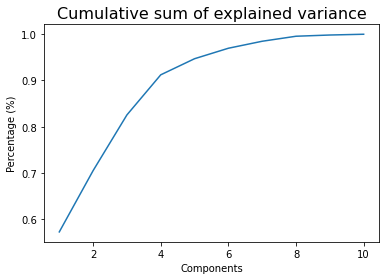

In [ ]:
#plot explained variance ratio 
plt.plot(range(1, len(pve) + 1), pve.cumsum())
plt.title('Cumulative sum of explained variance', fontsize=16)
plt.xlabel('Components')
plt.ylabel('Percentage (%)')
plt.show()

##Feature importance


In [ ]:
#Feature importance graph generated by Random Forest
X = shots.drop(['hit'], axis = 1)
Y = shots['hit']
X = pd.get_dummies(X, prefix_sep='_')
Y = LabelEncoder().fit_transform(Y)

X2 = StandardScaler().fit_transform(X)

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X2, Y, test_size = 0.30,  random_state = 101)
trainedforest = RandomForestClassifier(n_estimators=700).fit(X_Train,Y_Train)


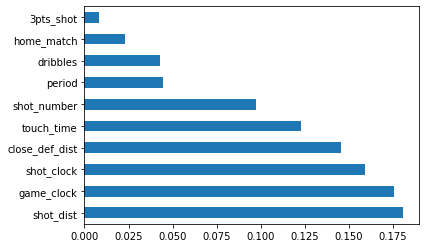

In [ ]:
feat_importances = pd.Series(trainedforest.feature_importances_, index= X.columns)
feat_importances.nlargest(30).plot(kind='barh')

##split dataset

In [ ]:
# Define X and Y
X = shots.drop('hit', axis = 1).values
y = shots['hit'].values

# Splitting dataset using 80/20 split
x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state=42)



# Splitting scaled dataset.
X_scaled = pca.transform(shots_scaled.drop('hit', axis = 1).values)[:,:4]
x_train_scaled, x_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size = 0.2, random_state=42)

##random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
randomforest_model = RandomForestClassifier()
randomforest_model.fit(x_train_scaled, y_train_scaled)

predictions = randomforest_model.predict(x_test_scaled)

actuals = y_test_scaled

print(confusion_matrix(actuals, predictions))
print("precision_score:",precision_score(actuals, predictions))
print("accuracy_score:", accuracy_score(actuals, predictions))

[[9673 4323]
 [7236 4382]]
precision_score: 0.5033888569787478
accuracy_score: 0.548723354415554


##Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
LR_model = LogisticRegression()
LR_model.fit(x_train_scaled, y_train_scaled)

predictions = LR_model.predict(x_test_scaled)

actuals = y_test_scaled

print(confusion_matrix(actuals, predictions))
print("precision_score:",precision_score(actuals, predictions))
print("accuracy_score:", accuracy_score(actuals, predictions))

[[11966  2030]
 [ 9047  2571]]
precision_score: 0.5587915670506411
accuracy_score: 0.5675411884125868


##Naive Bayes


In [ ]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB

mnb=GaussianNB()
mnb_model = mnb.fit(x_train_scaled, y_train_scaled)
predictions = mnb_model.predict(x_test_scaled)

actuals = y_test_scaled

print(confusion_matrix(actuals, predictions))
print("precision_score:",precision_score(actuals, predictions))
print("accuracy_score:", accuracy_score(actuals, predictions))

[[11319  2677]
 [ 8544  3074]]
precision_score: 0.5345157363936707
accuracy_score: 0.5619192629030999


##Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier()
mlp_model = mlp.fit(x_train_scaled, y_train_scaled)
predictions = mlp_model.predict(x_test_scaled)

actuals = y_test_scaled

print(confusion_matrix(actuals, predictions))
print("precision_score:",precision_score(actuals, predictions))
print("accuracy_score:", accuracy_score(actuals, predictions))


[[11326  2670]
 [ 8105  3513]]
precision_score: 0.5681707908782144
accuracy_score: 0.579331615522761


##XGBOOST

In [ ]:
xgb_model = XGBClassifier().fit(x_train_scaled, y_train_scaled)
predictions = xgb_model.predict(x_test_scaled)
actuals = y_test_scaled

print(confusion_matrix(actuals, predictions))
print(accuracy_score(actuals, predictions) )





parameters_for_testing = {
    'min_child_weight':[0.0001,0.001,0.01,0.1],
    'learning_rate':[0.00001,0.0001,0.001],
    'n_estimators':[1,2,3,5,10],
    'subsample':np.linspace(0.7,0.9,20),
    'max_depth':[2,3,4,5]
    'colsample_bytree':np.linspace(0.5,0.98,10)
}
'''
parameters_for_testing = {
    'min_child_weight':[0.0001,0.001,0.01,0.1],
    'learning_rate':[0.0001,0.001],
    'n_estimators':[1,3,5,10],
    'max_depth':[3,4]
}
'''
# Parameter tuning using 7 features
xgb_model = XGBClassifier()

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, scoring='accuracy')
gsearch1.fit(x_train_scaled,y_train_scaled)

print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

[[11515  2481]
 [ 8184  3434]]
0.5836261419536191
best params
{'learning_rate': 1e-05, 'max_depth': 5, 'min_child_weight': 0.0001, 'n_estimators': 1}
best score
0.6163175789707711


##SVM

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC

In [ ]:
svm=SVC()
svm_model = svm.fit(x_train_scaled, y_train_scaled)
predictions = svm_model.predict(x_test_scaled)

actuals = y_test_scaled

print(confusion_matrix(actuals, predictions))
print("precision_score:",precision_score(actuals, predictions))
print("accuracy_score:", accuracy_score(actuals, predictions))

[[12220  1776]
 [ 9011  2607]]
precision_score: 0.594798083504449
accuracy_score: 0.5788631217303037


In [ ]:
'''from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

scores = ["precision", "recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(x_train_scaled, y_train_scaled)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test_scaled)
    print(classification_report(y_true, y_pred))
    print() '''

### LSTM

In [ ]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb 
n_unique_words = 10000 
maxlen = 200
batch_size = 128 


In [ ]:
 x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
 x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
 y_train = np.array(y_train)
 y_test = np.array(y_test) 

In [ ]:
model = Sequential()
model.add(Embedding(n_unique_words, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 


In [ ]:
history=model.fit(x_train, y_train,
           batch_size=batch_size,
           epochs=12,
           validation_data=[x_test, y_test])
print(history.history['loss'])
print(history.history['accuracy']) 

Epoch 1/12
801/801 [==============================] - 544s 674ms/step - loss: 0.6685 - accuracy: 0.5947 - val_loss: 0.6568 - val_accuracy: 0.6124
Epoch 2/12
801/801 [==============================] - 540s 674ms/step - loss: 0.6536 - accuracy: 0.6171 - val_loss: 0.6575 - val_accuracy: 0.6133
Epoch 3/12
801/801 [==============================] - 547s 683ms/step - loss: 0.6512 - accuracy: 0.6194 - val_loss: 0.6563 - val_accuracy: 0.6127
Epoch 4/12
801/801 [==============================] - 544s 680ms/step - loss: 0.6495 - accuracy: 0.6207 - val_loss: 0.6569 - val_accuracy: 0.6138
Epoch 5/12
801/801 [==============================] - 543s 678ms/step - loss: 0.6475 - accuracy: 0.6212 - val_loss: 0.6568 - val_accuracy: 0.6101
Epoch 6/12
801/801 [==============================] - 541s 675ms/step - loss: 0.6458 - accuracy: 0.6236 - val_loss: 0.6584 - val_accuracy: 0.6132
Epoch 7/12
801/801 [==============================] - 540s 675ms/step - loss: 0.6438 - accuracy: 0.6255 - val_loss: 0.6607 -

In [ ]:
import statistics
x = statistics.mean(history.history['accuracy'])
print("Mean is :", x)
 

Mean is : 0.6238429844379425


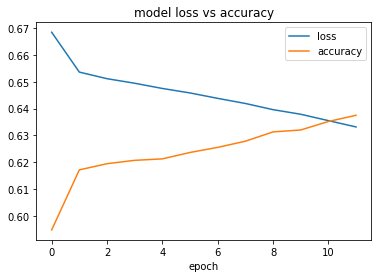

In [ ]:
 from matplotlib import pyplot
 pyplot.plot(history.history['loss'])
 pyplot.plot(history.history['accuracy'])
 pyplot.title('model loss vs accuracy')
 pyplot.xlabel('epoch')
 pyplot.legend(['loss', 'accuracy'], loc='upper right')
 pyplot.show() 

##k-fold

In [ ]:
from sklearn.model_selection import StratifiedKFold
folds=StratifiedKFold(n_splits=10)
folds

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [ ]:
def get_score(model, x_train, x_test, y_train, y_test):
  model.fit(x_train_scaled, y_train_scaled)
  y_pred_train=model.predict(x_test_scaled)
  return accuracy_score(y_test_scaled, y_pred_train)
  

In [ ]:
scores_RF=[]
scores_XGboost=[]
scores_SVM=[]
scores_Logistic=[]
scores_NN=[]
scores_NB=[]

for train_index, test_index in folds.split(X,y):
  x_train, x_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
  scores_RF.append(get_score(RandomForestClassifier(),x_train, x_test, y_train, y_test))
  scores_XGboost.append(get_score(XGBClassifier(),x_train, x_test, y_train, y_test))
  scores_SVM.append(get_score(SVC(),x_train, x_test, y_train, y_test))
  scores_Logistic.append(get_score(LogisticRegression(),x_train, x_test, y_train, y_test))
  scores_NN.append(get_score(MLPClassifier(),x_train, x_test, y_train, y_test))
  scores_NB.append(get_score(GaussianNB(),x_train, x_test, y_train, y_test))

In [ ]:
print("RF_scores" ,scores_RF)
print("XGboost_scores" ,scores_XGboost)
print("SVM_scores" ,scores_SVM)
print("Logistic_scores" ,scores_Logistic)
print("NN_scores" ,scores_NN)
print("NB_scores" ,scores_NB)
